In [ ]:
!unzip '/content/drive/MyDrive/splitdata_three-20221118T001338Z-001.zip' -d /content/drive/MyDrive/

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/splitdata_three/train/Bhairavi/Bhairavi.Viribonimp3-41.png  
  inflating: /content/drive/MyDrive/splitdata_three/train/Dhanyasi/Dhanyasi.Dhyanamemp3-22.png  
  inflating: /content/drive/MyDrive/splitdata_three/train/Dhanyasi/Dhanyasi.Dhyanamemp3-21.png  
  inflating: /content/drive/MyDrive/splitdata_three/train/Bhairavi/Bhairavi.Viribonimp3-54.png  
  inflating: /content/drive/MyDrive/splitdata_three/train/Bhairavi/Bhairavi.Viribonimp3-59.png  
  inflating: /content/drive/MyDrive/splitdata_three/train/Dhanyasi/Dhanyasi.Dhyanamemp3-20.png  
  inflating: /content/drive/MyDrive/splitdata_three/train/Bhairavi/Bhairavi.Viribonimp3-37.png  
  inflating: /content/drive/MyDrive/splitdata_three/train/Bhairavi/Bhairavi.Viribonimp3-39.png  
  inflating: /content/drive/MyDrive/splitdata_three/train/Bhairavi/Bhairavi.Viribonimp3-43.png  
  inflating: /content/drive/MyDrive/splitdata_three/train/Bhairavi/Bhairavi.

In [ ]:
import librosa
import numpy as np
import os
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
import tensorflow.keras.layers as layers
import keras
import tensorflow as tf
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.optimizers import Adam
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import librosa.display
import pylab

In [ ]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.1,
                                             directory= os.path.join('/content/drive/MyDrive/splitdata_three/train'),
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.1,
                                             directory= os.path.join('/content/drive/MyDrive/splitdata_three/train'),
                                             shuffle=False,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

Found 6048 files belonging to 10 classes.
Using 5444 files for training.
Found 6048 files belonging to 10 classes.
Using 604 files for validation.


In [ ]:
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])
    
    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             directory= os.path.join('/content/drive/MyDrive/splitdata_three/val'),
                                             color_mode='rgb',
                                             image_size=(256, 256),
                                             batch_size=BATCH_SIZE,
                                             shuffle = False ,
                                             seed=0)

Found 672 files belonging to 10 classes.


In [ ]:
def preparetest(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    # flip_and_rotate = tf.keras.Sequential([
    #     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    #     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    # ])
    
    # # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    # if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

test_dataset = preparetest(test_dataset, augment=False)

In [ ]:
y = np.concatenate([y for x, y in test_dataset], axis=0)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [ ]:
np.save('/content/drive/MyDrive/img_testset.npy', y)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
# model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization_18 (Bat  (None, 256, 256, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 batch_normalization_19 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 128)     73856     
                                                     

In [ ]:
# # Early Stopping
# early_stopping_callback = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=0,
#     patience=20,
#     verbose=0,
#     mode="auto",
#     baseline=None,
#     restore_best_weights=True,
# )

# history = model.fit(train_dataset, validation_data=valid_dataset, epochs=12, callbacks = early_stopping_callback)

Epoch 1/12
171/171 [==============================] - 1865s 11s/step - loss: 2.5834 - accuracy: 0.2325 - val_loss: 10.8943 - val_accuracy: 0.0166
Epoch 2/12
171/171 [==============================] - 42s 238ms/step - loss: 1.9128 - accuracy: 0.3924 - val_loss: 10.2546 - val_accuracy: 0.0000e+00
Epoch 3/12
171/171 [==============================] - 42s 239ms/step - loss: 1.6464 - accuracy: 0.4816 - val_loss: 1.0768 - val_accuracy: 0.6258
Epoch 4/12
171/171 [==============================] - 42s 239ms/step - loss: 1.3087 - accuracy: 0.5724 - val_loss: 2.0710 - val_accuracy: 0.2732
Epoch 5/12
171/171 [==============================] - 42s 241ms/step - loss: 0.9485 - accuracy: 0.6960 - val_loss: 3.2938 - val_accuracy: 0.0911
Epoch 6/12
171/171 [==============================] - 42s 241ms/step - loss: 0.7183 - accuracy: 0.7616 - val_loss: 0.2941 - val_accuracy: 0.9255
Epoch 7/12
171/171 [==============================] - 42s 242ms/step - loss: 0.4529 - accuracy: 0.8505 - val_loss: 0.2858 - 

In [ ]:
img_preds = model.predict(test_dataset)

21/21 [==============================] - 3s 136ms/step


In [ ]:
img_preds

array([[8.5468715e-01, 9.4895564e-05, 1.4480247e-01, ..., 1.0166797e-04,
        5.1001683e-07, 1.4167835e-08],
       [9.9927205e-01, 5.0002447e-04, 7.1216287e-05, ..., 2.0691093e-07,
        1.7271047e-07, 1.6731175e-08],
       [3.2555705e-01, 1.3563298e-03, 6.7029226e-01, ..., 6.8386267e-05,
        3.7871545e-05, 6.1990118e-05],
       ...,
       [5.4471661e-06, 4.0296679e-03, 1.1243602e-03, ..., 7.3542587e-02,
        4.4342162e-04, 8.8898224e-01],
       [9.4008341e-04, 6.8860239e-04, 8.7192487e-03, ..., 6.8497235e-01,
        3.8636066e-05, 2.1254247e-01],
       [1.1965072e-05, 7.1752383e-03, 2.3415575e-03, ..., 1.2254663e-04,
        8.5212319e-04, 6.3634837e-01]], dtype=float32)

In [ ]:
np.save('/content/drive/MyDrive/img_preds.npy', img_preds)

In [ ]:
# preds = np.load('/content/drive/MyDrive/img_preds.npy')
preds = tf.math.argmax(input = img_preds, axis= 1)
preds

<tf.Tensor: shape=(672,), dtype=int64, numpy=
array([0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 7, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 1, 1, 3, 1,
       1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 4, 4, 1, 1, 4, 1, 1, 1, 1, 1, 7,
       1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 7, 7, 8,
       7, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 7, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 9, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 9, 9, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 4, 3, 3, 8, 3, 5,
       3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3,
       4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 4, 3, 3, 3, 4, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
     

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
actual.shape

(672,)

In [ ]:
pd.crosstab(preds,y)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,53,4,0,1,0,1,1,0,0,0
1,0,49,0,0,0,1,2,0,2,2
2,3,1,55,0,5,1,8,1,3,3
3,0,1,0,59,2,1,1,0,5,1
4,0,5,1,7,54,6,6,3,8,3
5,2,1,0,1,0,54,0,0,2,0
6,0,0,0,0,1,0,43,0,0,0
7,4,4,1,2,3,2,3,61,3,1
8,0,1,2,2,1,0,1,0,45,2


# Trial 2

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
# model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                      

In [ ]:
# # Early Stopping
# early_stopping_callback = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=0,
#     patience=20,
#     verbose=0,
#     mode="auto",
#     baseline=None,
#     restore_best_weights=True,
# )

# history = model.fit(train_dataset, validation_data=valid_dataset, epochs=20, callbacks = early_stopping_callback)

Epoch 1/20
171/171 [==============================] - 1173s 6s/step - loss: 2.5421 - accuracy: 0.1714 - val_loss: 3.5658 - val_accuracy: 0.0000e+00
Epoch 2/20
171/171 [==============================] - 44s 248ms/step - loss: 1.9185 - accuracy: 0.3376 - val_loss: 5.0680 - val_accuracy: 0.0000e+00
Epoch 3/20
171/171 [==============================] - 43s 247ms/step - loss: 1.6253 - accuracy: 0.4460 - val_loss: 2.9367 - val_accuracy: 0.0000e+00
Epoch 4/20
171/171 [==============================] - 44s 252ms/step - loss: 0.9380 - accuracy: 0.7122 - val_loss: 1.8378 - val_accuracy: 0.2268
Epoch 5/20
171/171 [==============================] - 43s 247ms/step - loss: 0.5327 - accuracy: 0.8543 - val_loss: 0.2601 - val_accuracy: 0.9305
Epoch 6/20
171/171 [==============================] - 44s 249ms/step - loss: 0.2708 - accuracy: 0.9355 - val_loss: 0.1559 - val_accuracy: 0.9685
Epoch 7/20
171/171 [==============================] - 44s 249ms/step - loss: 0.1205 - accuracy: 0.9770 - val_loss: 0.30

In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             directory= os.path.join('/content/drive/MyDrive/splitdata_three/val'),
                                             color_mode='rgb',
                                             image_size=(256, 256),
                                             batch_size=BATCH_SIZE,
                                             shuffle = False ,
                                             seed=0)

Found 672 files belonging to 10 classes.


In [ ]:
def preparetest(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    # flip_and_rotate = tf.keras.Sequential([
    #     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    #     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    # ])
    
    # # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    # if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

test_dataset = preparetest(test_dataset, augment=False)

In [ ]:
y = np.concatenate([y for x, y in test_dataset], axis=0)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [ ]:
preds = model.predict(test_dataset)
predclasses = tf.math.argmax(input = preds, axis= 1)
predclasses

21/21 [==============================] - 3s 141ms/step


<tf.Tensor: shape=(672,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 9, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 5, 1, 1, 4, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 7, 7, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 4, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 9, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 6, 2, 2, 2, 2, 2,
       2, 2, 2, 9, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
     

In [ ]:
pd.crosstab(predclasses, y) #90.77% for 99% and 98%

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,61,1,1,0,0,0,1,0,0,0
1,0,57,0,0,0,1,0,0,0,2
2,0,0,55,0,1,0,0,1,0,0
3,0,0,0,67,3,0,2,0,2,1
4,0,3,2,3,56,2,1,2,1,1
5,1,1,0,1,0,64,0,0,3,0
6,0,1,2,1,4,0,64,0,0,1
7,0,2,0,0,1,0,0,64,0,0
8,0,0,0,0,0,0,0,0,64,3


In [ ]:
np.save('/content/drive/MyDrive/img_preds2.npy', preds)
np.save('/content/drive/MyDrive/img_testset2.npy', y)

In [ ]:
Y_pred = np.load('/content/drive/MyDrive/img_preds2.npy')
Y_test = np.load('/content/drive/MyDrive/img_testset2.npy')

In [ ]:
import pandas as pd
Y_pred = tf.math.argmax(Y_pred, axis=1)
Y_pred = pd.DataFrame(Y_pred)
Y_test = pd.DataFrame(Y_test)
Y_pred.columns = ['predicted']
Y_test.columns = ['true']

In [ ]:
Y_pred['predicted'] = Y_pred['predicted'].replace(0,"At")
Y_pred['predicted'] = Y_pred['predicted'].replace(1,"Beg")
Y_pred['predicted'] = Y_pred['predicted'].replace(2,"Beh")
Y_pred['predicted'] = Y_pred['predicted'].replace(3,"Bh")
Y_pred['predicted'] = Y_pred['predicted'].replace(4,"Bi")
Y_pred['predicted'] = Y_pred['predicted'].replace(5,"Dh")
Y_pred['predicted'] = Y_pred['predicted'].replace(6,"Har")
Y_pred['predicted'] = Y_pred['predicted'].replace(7,"Hus")
Y_pred['predicted'] = Y_pred['predicted'].replace(8,"Kal")
Y_pred['predicted'] = Y_pred['predicted'].replace(9,"Kam")

In [ ]:
Y_test['true'] = Y_test['true'].replace(0,"At")
Y_test['true'] = Y_test['true'].replace(1,"Beg")
Y_test['true'] = Y_test['true'].replace(2,"Beh")
Y_test['true'] = Y_test['true'].replace(3,"Bh")
Y_test['true'] = Y_test['true'].replace(4,"Bi")
Y_test['true'] = Y_test['true'].replace(5,"Dh")
Y_test['true'] = Y_test['true'].replace(6,"Har")
Y_test['true'] = Y_test['true'].replace(7,"Hus")
Y_test['true'] = Y_test['true'].replace(8,"Kal")
Y_test['true'] = Y_test['true'].replace(9,"Kam")

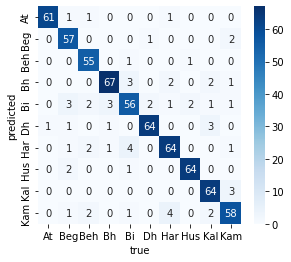

In [ ]:
cm_2Dcnn = pd.crosstab(Y_pred['predicted'], Y_test['true'])
import seaborn as sn
fig = plt.figure(figsize = (10, 4))
ax1 = plt.subplot(121)
sn.heatmap(cm_2Dcnn, annot= True, cmap= 'Blues')

In [ ]:
for i in range(cm_2Dcnn.shape[0]):
    tp = cm_2Dcnn.iloc[i,i]
    fp = cm_2Dcnn.iloc[i,:].sum()- tp
    fn = cm_2Dcnn.iloc[:,i].sum() - tp
    tn = cm_2Dcnn.sum().sum() - tp - fp - fn
    correct = tp + tn
    print(cm_2Dcnn.index[i], correct)
print(cm_2Dcnn.sum().sum())

At 668
Beg 660
Beh 663
Bh 659
Bi 647
Dh 663
Har 655
Hus 666
Kal 661
Kam 654
672


# Trial3

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
# model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                      

In [ ]:
# Early Stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

history = model.fit(train_dataset, validation_data=valid_dataset, epochs=12, callbacks = early_stopping_callback)

Epoch 1/12
171/171 [==============================] - 2148s 12s/step - loss: 2.5200 - accuracy: 0.1710 - val_loss: 2.0060 - val_accuracy: 0.0166
Epoch 2/12
171/171 [==============================] - 44s 254ms/step - loss: 2.1311 - accuracy: 0.2551 - val_loss: 3.1552 - val_accuracy: 0.0166
Epoch 3/12
171/171 [==============================] - 43s 247ms/step - loss: 1.6994 - accuracy: 0.4199 - val_loss: 2.7354 - val_accuracy: 0.0331
Epoch 4/12
171/171 [==============================] - 44s 250ms/step - loss: 1.3316 - accuracy: 0.5746 - val_loss: 1.4073 - val_accuracy: 0.5480
Epoch 5/12
171/171 [==============================] - 44s 252ms/step - loss: 1.0633 - accuracy: 0.6729 - val_loss: 5.3861 - val_accuracy: 0.0017
Epoch 6/12
171/171 [==============================] - 43s 248ms/step - loss: 0.7425 - accuracy: 0.7812 - val_loss: 0.6080 - val_accuracy: 0.7649
Epoch 7/12
171/171 [==============================] - 44s 254ms/step - loss: 0.4584 - accuracy: 0.8727 - val_loss: 0.2334 - val_ac

In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             directory= os.path.join('/content/drive/MyDrive/splitdata_three/val'),
                                             color_mode='rgb',
                                             image_size=(256, 256),
                                             batch_size=BATCH_SIZE,
                                             shuffle = False ,
                                             seed=0)

Found 672 files belonging to 10 classes.


In [ ]:
def preparetest(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    # flip_and_rotate = tf.keras.Sequential([
    #     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    #     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    # ])
    
    # # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    # if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

test_dataset = preparetest(test_dataset, augment=False)

In [ ]:
y = np.concatenate([y for x, y in test_dataset], axis=0)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [ ]:
preds = model.predict(test_dataset)
predclasses = tf.math.argmax(input = preds, axis= 1)
predclasses

21/21 [==============================] - 3s 136ms/step


<tf.Tensor: shape=(672,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0,
       6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 0, 0, 0, 1, 1, 1, 1, 1, 1, 7, 4, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       0, 4, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 9, 2, 2, 2, 3, 2, 6, 6, 2,
       2, 2, 2, 2, 2, 9, 6, 4, 2, 0, 0, 2, 2, 4, 2, 2, 5, 8, 2, 2, 2, 2,
       2, 2, 2, 9, 9, 9, 2, 2, 5, 2, 0, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 8, 3, 5,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4,
     

In [ ]:
pd.crosstab(predclasses, y)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,58,5,7,0,2,1,1,0,1,0
1,0,57,0,1,1,4,0,0,0,2
2,0,0,40,0,0,0,0,0,0,0
3,2,1,1,65,2,2,3,0,7,1
4,0,1,3,1,52,0,1,2,5,1
5,1,0,2,1,0,59,0,0,4,0
6,1,1,3,2,5,0,65,1,6,7
7,0,1,0,0,2,1,1,64,1,0
8,0,0,1,2,1,0,0,0,45,2


In [ ]:
np.save('/content/drive/MyDrive/img_preds3.npy', preds)
np.save('/content/drive/MyDrive/img_testset3.npy', y)